# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
import ipywidgets as widgets
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            #("Landshut" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,188.0,185.0,172.0,165.0,180.0,185.0,170.0,157.0,158.0,121.0,157.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
startup_counter,138.0,105.0,100.0,101.0,100.0,97.0,93.0,85.0,93.0,82.0,90.0
shutdown_counter,138.0,107.0,100.0,101.0,101.0,99.0,93.0,85.0,93.0,84.0,95.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [4]:
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
display(dl)

Dropdown(description='Engine:', layout=Layout(width='max-content'), options=(('1486144 - Forsa Hartmoor M01', …

In [5]:
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M01,M01,AL87,624,H12,24,4495.0,24.5,1486144,159396,200.0,2022-01-10,63,137.0,0.119


In [6]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_days=7) #funktioniert nicht
#fsm = msgFSM(e, p_from=motor['Commissioning Date'], p_to=arrow.now() )
fsm = msgFSM(e)
fsm.run1() # run Finite State Machine

FSM: 100%|██████████████████████| 15973/15973 [00:01<00:00, 13800.46 messages/s]


In [7]:
# Struktur zur Aufnahme mehrerer motoren
fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

In [8]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
fsm.summary(res)

,From,To,Days
Interval,27.10.2021,25.02.2022,120


,Starts,successful,%
???,0,0,0
OFF,11,1,9
MANUAL,90,29,32
AUTO,105,81,77
ALL,206,111,53


In [9]:
rmodes = ['???','OFF','MANUAL','AUTO']; mw = [] ; modes = []
for mm in rmodes:
    mw.append(widgets.Checkbox(value=False, description='Mode: ' + mm))
display(widgets.VBox(mw))

In [10]:
rsucc = [True,False]; sw = []; success=[]
for rs in rsucc:
    sw.append(widgets.Checkbox(value=False, description='Success: ' + str(rs)))
display(widgets.VBox(sw))

In [11]:
rdf = res['result']
modes = [rmodes[i] for i,v in enumerate(mw) if v.value]
modes = rmodes if not modes else modes
success = [rsucc[i] for i,v in enumerate(sw) if v.value]
success = rsucc if not success else success

rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')
print(modes, success)

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [12]:
# special filters can be added like ... 
#rda = rda[((rda['loadramp'] < 80.0) & (rda['startpreparation'] < 300.0))].reset_index(drop='index')

# rda = rda[((rda['count_warnings'] == 0) & (rda['count_alarms'] == 0))].reset_index(drop='index')
# display the filterd & selected data
rda[fsm.filters['filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation,count_alarms,count_warnings
0,False,MANUAL,295.95,NaN,NaN,NaN,NaN,NaN,295.95,NaT,0,0
1,False,MANUAL,111.48,3.84,33.71,147.75,NaN,NaN,296.77,NaT,0,0
2,False,MANUAL,870.73,3.54,25.22,21.19,117.63,NaN,1038.31,NaT,1,3
3,False,MANUAL,103.14,4.24,22.80,20.10,40.47,53.98,244.72,NaT,0,3
4,False,MANUAL,67.79,4.23,18.17,5.76,45.21,69.90,211.06,NaT,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
201,True,AUTO,99.79,3.83,24.41,4.84,59.45,85.07,277.39,0 days 05:13:30,0,0
202,True,AUTO,99.34,4.15,23.30,4.64,64.47,81.53,277.44,0 days 03:13:30,0,0
203,True,AUTO,103.73,3.84,23.71,4.74,48.64,92.35,277.00,0 days 01:43:30,0,0
204,True,AUTO,104.40,3.83,25.32,4.84,1.71,135.81,275.92,0 days 01:33:33,0,0


In [13]:
rda = fsm.run2(rda)

FSM Run2: 100%|██████████████████████████| 206/206 [00:55<00:00,  3.68 starts/s]


In [14]:
rdb = rda[(rda['mode'] == 'AUTO') & rda['success'] & (rda['maxload'] > 4000.0)]
rdb[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,index,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,count_alarms,count_warnings
25,25,True,AUTO,100.79,3.74,20.77,5.85,40.43,127.09,298.66,4487.16,0.79,0 days 00:10:50,1,2
35,35,True,AUTO,60.53,3.53,19.28,5.35,35.52,959.55,1083.75,4504.00,0.10,0 days 03:02:00,0,2
62,62,True,AUTO,168.09,3.63,9.60,5.36,52.41,129.36,368.45,4503.50,0.77,0 days 00:24:33,0,0
66,66,True,AUTO,101.11,3.63,23.82,6.46,53.48,131.24,319.73,4511.00,0.76,0 days 03:07:54,0,0
70,70,True,AUTO,167.36,4.23,24.23,6.26,59.46,136.46,398.00,4511.00,0.74,0 days 00:28:52,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,True,AUTO,99.79,3.83,24.41,4.84,59.45,87.62,279.94,4502.93,1.14,0 days 05:13:30,0,0
202,202,True,AUTO,99.34,4.15,23.30,4.64,64.47,84.46,280.37,4511.00,1.19,0 days 03:13:30,0,0
203,203,True,AUTO,103.73,3.84,23.71,4.74,48.64,97.30,281.96,4528.00,1.04,0 days 01:43:30,0,0
204,204,True,AUTO,104.40,3.83,25.32,4.84,1.71,140.14,280.24,4507.82,0.72,0 days 01:33:33,0,0


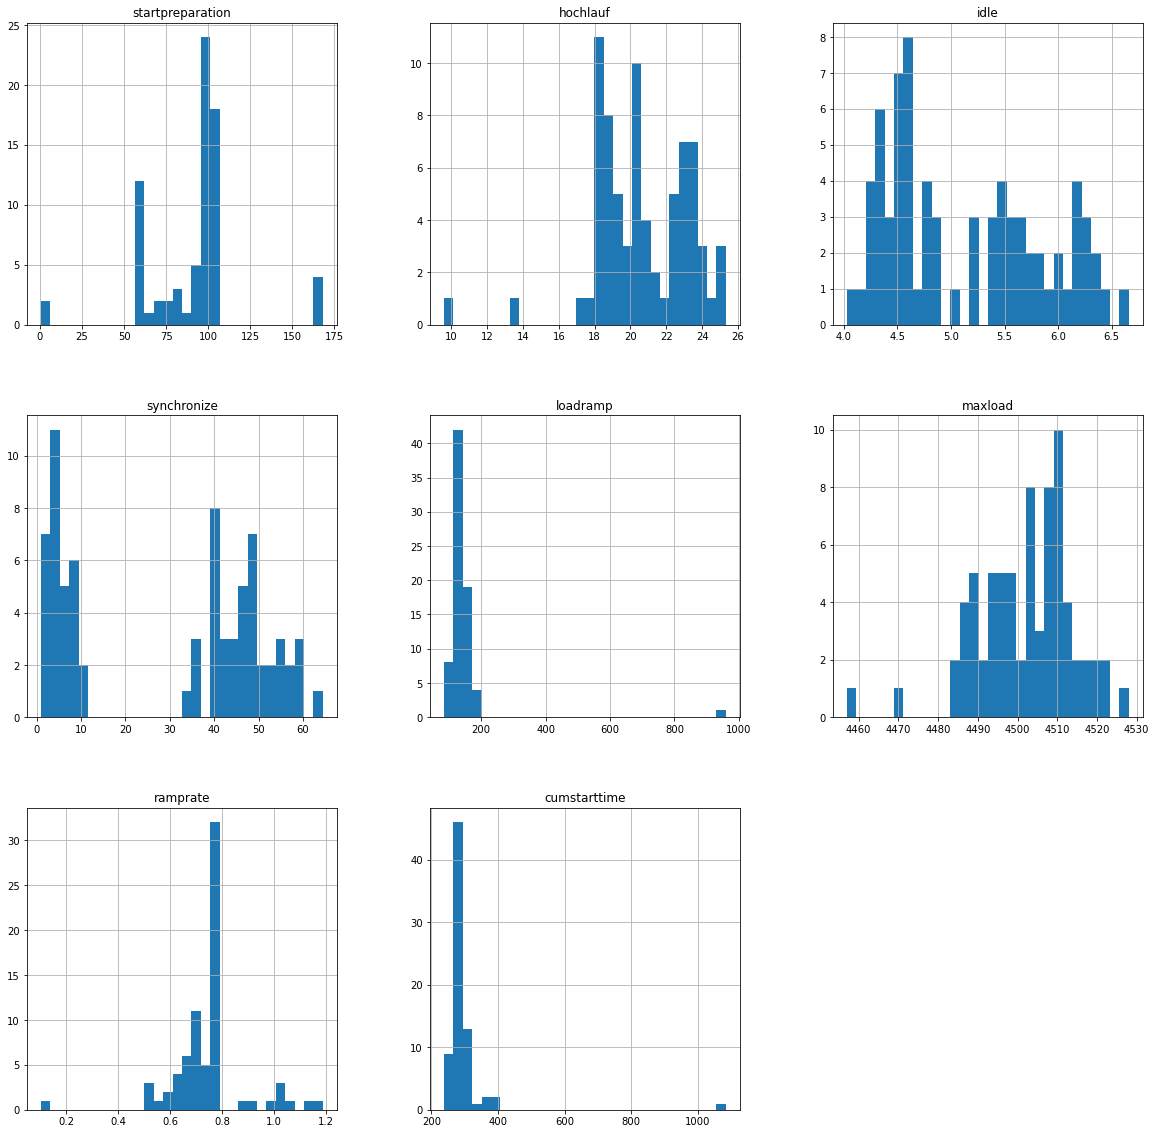

In [16]:
rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime']].hist(bins=30,figsize=(20,20));

In [17]:
startversuch = rda.iloc[3];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())

cycle = 1 #sec.
data = fsm.get_period_data(von, bis, cycletime=cycle)
ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von: {von_dt} = {von} bis: {bis_dt} = {bis}")
data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1)

von: 2021-11-19 09:01:04.264000 = 1637312464 bis: 2021-11-19 09:05:08.983000064 = 1637312708


In [18]:
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000)},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
]
dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(6,4))

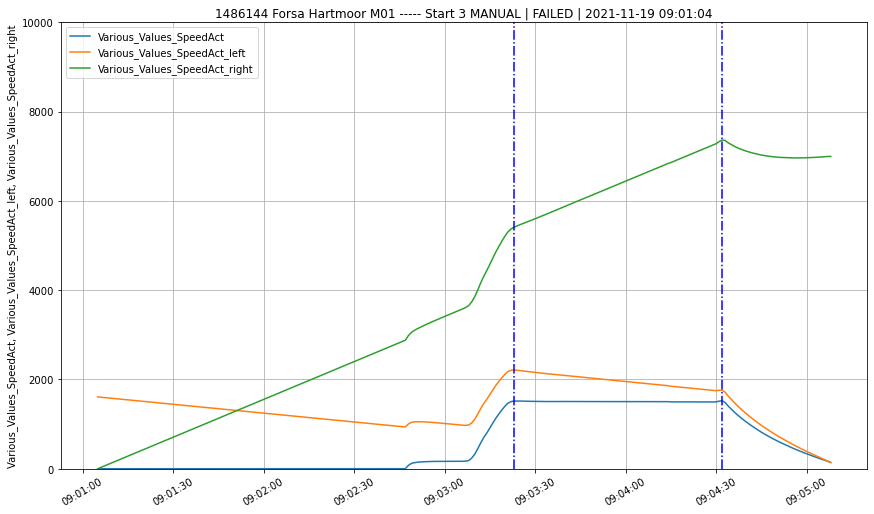

In [19]:
dset = [
    {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,10000)}
]
pl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
pr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

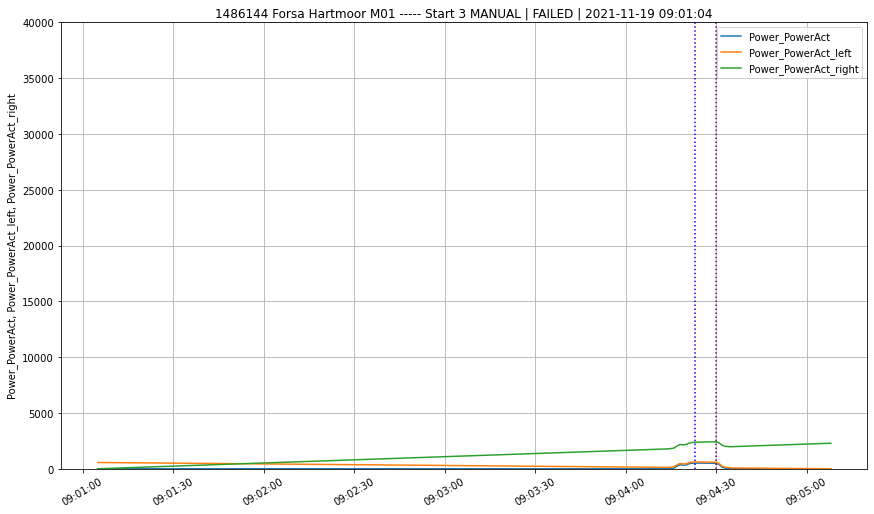

In [20]:
dset = [
    {'col':['Power_PowerAct','Power_PowerAct_left','Power_PowerAct_right'], 'ylim':(0,40000)}
]
pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle=":")
dmyplant2.add_lines(pr.loc, [], ax, color='purple', linestyle=":")

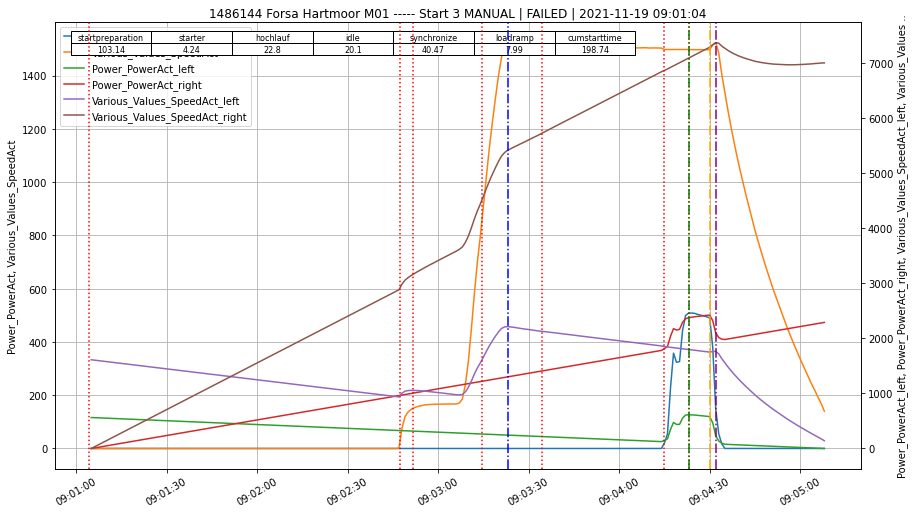

In [21]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,40000)},
    {'col':['Power_PowerAct_left','Power_PowerAct_right','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], '_ylim':(0,40000)}
    ]

pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)

sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_lines(start, lines, ax, color='red', linestyle="dotted")
dmyplant2.add_lines(sl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(sr.loc, [], ax, color='purple', linestyle="-.")
dmyplant2.add_lines(pl.loc, [], ax, color='green', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='orange', linestyle="-.")

summary = pd.DataFrame(startversuch[fsm.filters['filter_times']], dtype=np.float64).round(2).T
dmyplant2.add_table(summary, ax, loc='upper left')

plt.show()

/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_73481/3138381503.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,295.947,0.0,0.0,0.0,0.0,0.0,-,-,295.947
RUN2,295.95,0.0,0.0,0.0,0.0,0.0,0.0,NaN,295.95


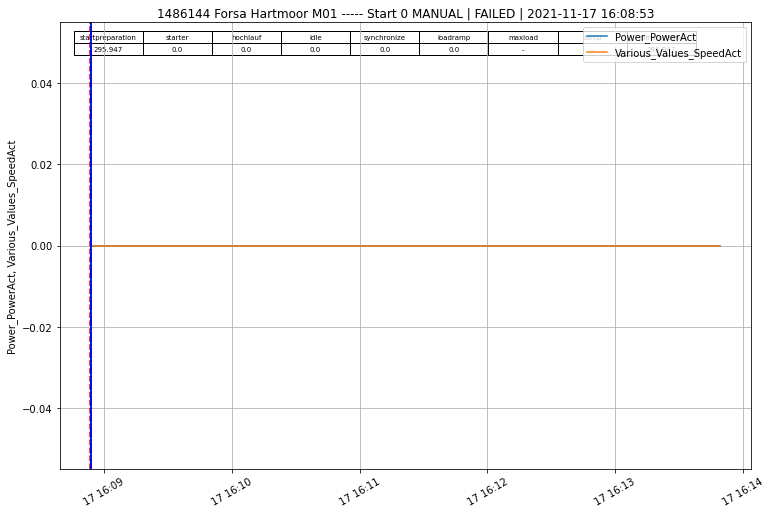

/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_73481/3138381503.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,111.475,3.836,33.711,147.752999,0.0,0.0,-,-,296.774999
RUN2,111.48,3.84,33.71,147.75,0.0,0.0,0.0,NaN,296.77


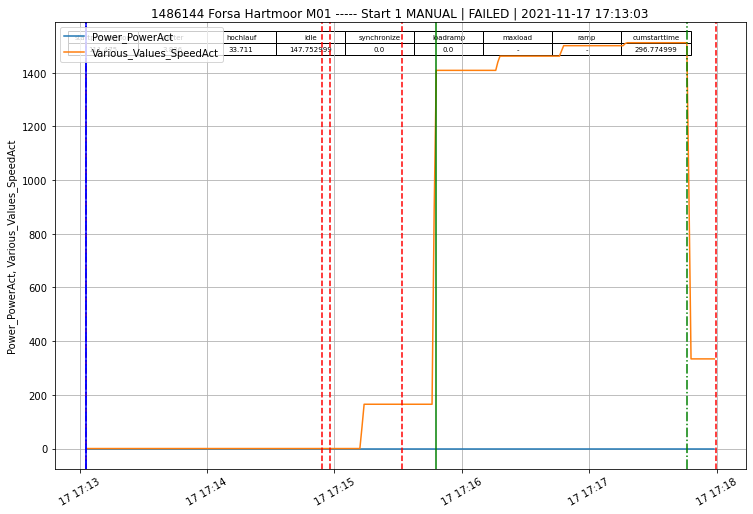

Load Data: 50000 datarows [00:00, 63855.41 datarows/s]                          
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_73481/3138381503.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,870.729999,3.541,25.221999,21.194,117.625999,0.0,-,-,1038.312997
RUN2,870.73,3.54,25.22,21.19,117.63,0.0,0.0,NaN,1038.31


synchronize      000000 800 1637233698281 18.11.2021 11:08:18  1056 Fail safe loop tripped
synchronize      000000 700 1637233644285 18.11.2021 11:07:24  9304 Deviation in switch-on time for generator switch
synchronize      000001 700 1637233697976 18.11.2021 11:08:17  1219 Generator CB closing failure
synchronize      000002 700 1637233698382 18.11.2021 11:08:18  3213 Gas proportioning valve fuel gas volume not reached


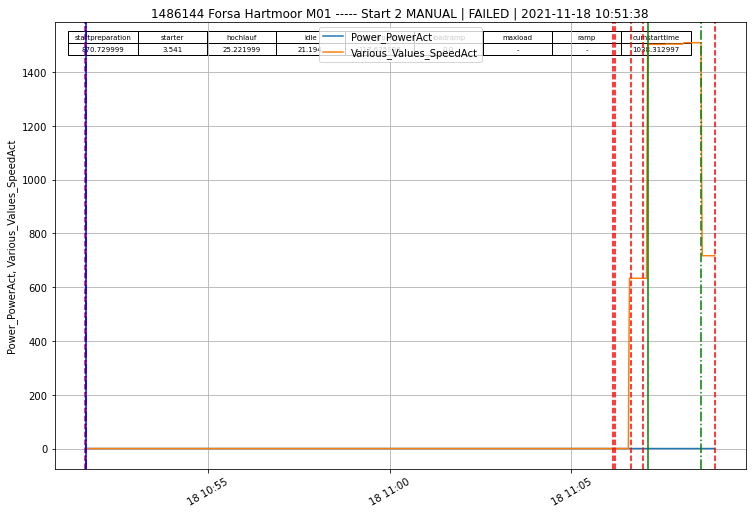

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,103.136,4.236999,22.804999,20.096,40.469,7.993002,-,-,198.736
RUN2,103.14,4.24,22.8,20.1,40.47,7.99,508.41,1.42,198.74


startpreparation 000000 700 1637312466586 19.11.2021 09:01:06  1195 Safety slam shut valve status signal failure
loadramp         000001 700 1637312671155 19.11.2021 09:04:31  1189 Release from synchronizing missing
loadramp         000002 700 1637312671155 19.11.2021 09:04:31  1175 Mains failure


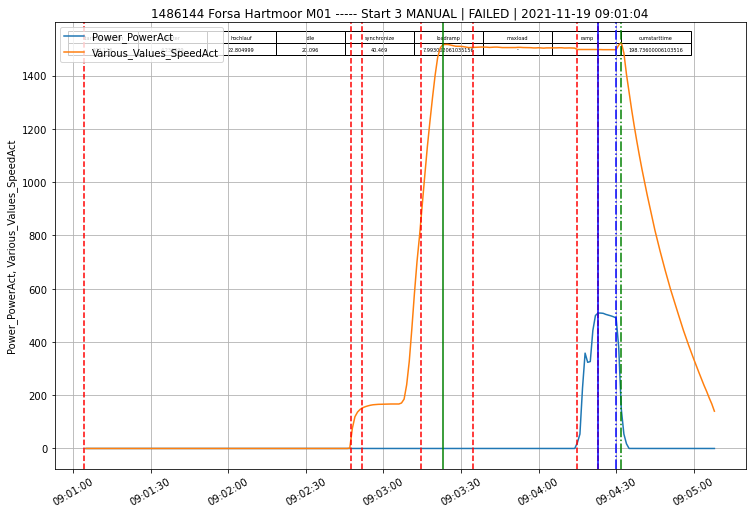

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,67.791,4.233999,18.167,5.760999,45.212999,7.683003,-,-,148.849
RUN2,67.79,4.23,18.17,5.76,45.21,7.68,523.77,1.52,148.85


loadramp         000000 800 1637313396595 19.11.2021 09:16:36  1134 Ground fault generator
loadramp         000001 800 1637313396595 19.11.2021 09:16:36  1036 Generator overload/short circuit
hochlauf         000000 700 1637313315093 19.11.2021 09:15:15  2476 CAM/Reset pickup signal deviation during engine operation
loadramp         000001 700 1637313396595 19.11.2021 09:16:36  3412 Mains monitoring device failure / generator protection relay failure


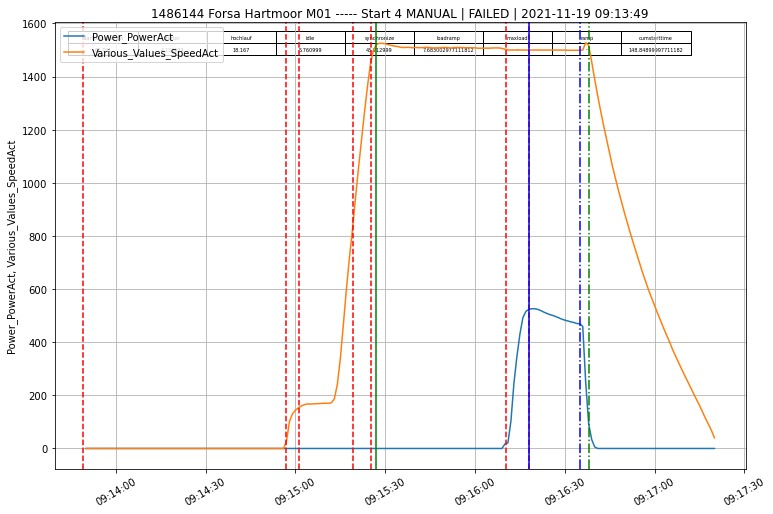

Load Data: 50000 datarows [00:00, 269402.72 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,113.631,4.016999,25.219,52.828999,18.672,8.540002,-,-,222.908
RUN2,113.63,4.02,25.22,52.83,18.67,8.54,508.49,1.32,222.91


loadramp         000000 700 1637496307561 21.11.2021 12:05:07  9304 Deviation in switch-on time for generator switch


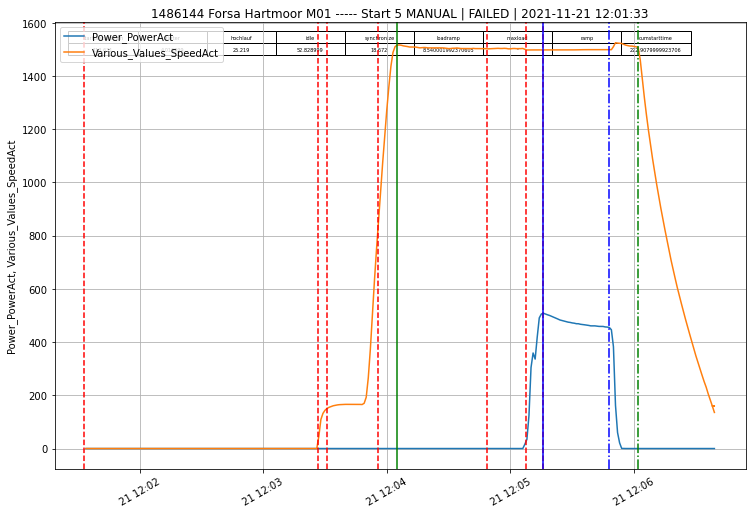

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,87.756,4.042999,17.553,17.260999,42.007,8.657002,-,-,177.277
RUN2,87.76,4.04,17.55,17.26,42.01,8.66,541.33,1.39,177.28


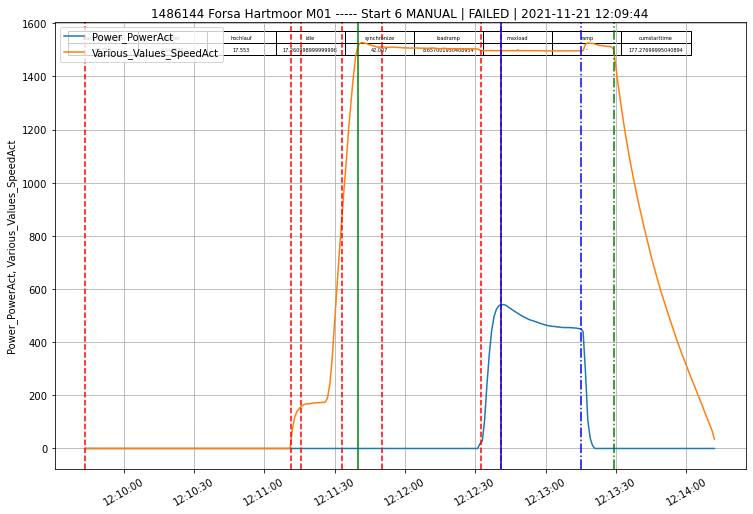

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,124.38,3.832,17.847,16.537999,30.480999,8.694002,-,-,201.772
RUN2,124.38,3.83,17.85,16.54,30.48,8.69,554.0,1.42,201.77


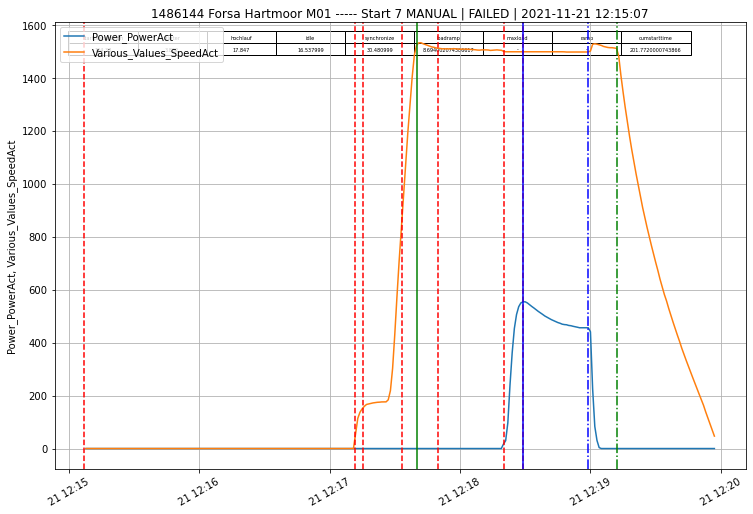

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,109.362,3.53,17.968999,21.32,29.048,8.169001,-,-,189.398
RUN2,109.36,3.53,17.97,21.32,29.05,8.17,572.99,1.56,189.4


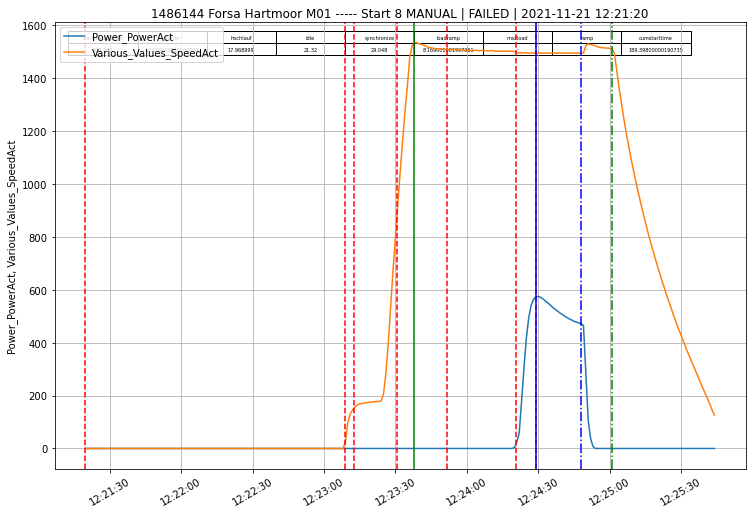

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,108.149,3.735,19.360999,15.433999,37.372,8.035002,-,-,192.086
RUN2,108.15,3.74,19.36,15.43,37.37,8.04,531.78,1.47,192.09


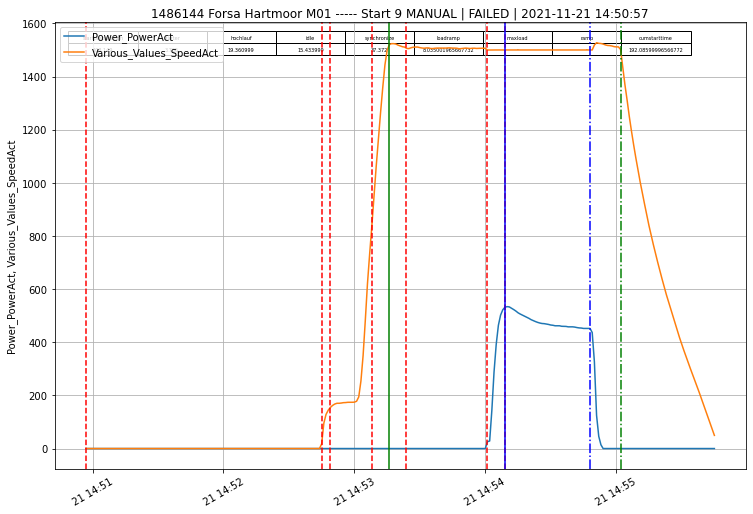

,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,71.224,4.036999,18.053,16.046999,39.607,7.868002,-,-,156.836
RUN2,71.22,4.04,18.05,16.05,39.61,7.87,553.92,1.57,156.84


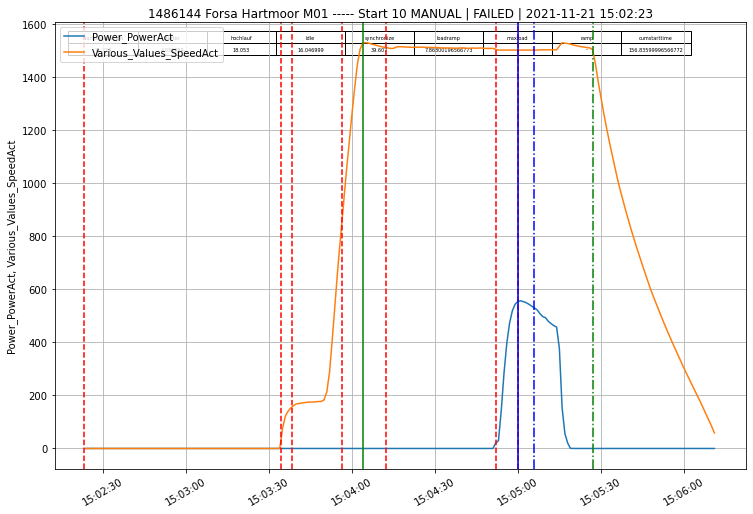

In [22]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,10000)}
]
for ii,startversuch in rda.iterrows():
        if ii < 0:
                continue
        if ii > 10:
                break
        data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1)

        pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
        pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
        sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
        sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')

        ftitle = f"{fsm._e} ----- Start {ii} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
        #ax, ax2, idf = dmyplant2._plot(data, style='.-', figsize=(18,10), title=ftitle);
        fig, ax, axes = dmyplant2.chart(data, dset, figsize=(12,8), title=ftitle)

        ml = (data.iloc[-1]['time'] - data.iloc[0]['time']) // 1000
        sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']]]

        start = startversuch['starttime'];
        
        nsv_lines = [v for v in sv_lines if ((v==v) and (v <= ml)) ]
        lines=list(np.cumsum(nsv_lines))
        dmyplant2.add_lines(start, lines, ax, color='red', linestyle="--")

        dmyplant2.add_lines(sl.loc, [], ax, color='green', linestyle="-")
        dmyplant2.add_lines(sr.loc, [], ax, color='green', linestyle="-.")
        dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-")
        dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

        svdf = pd.DataFrame(sv_lines, index=fsm.filters['vertical_lines_times'], columns=['FSM']).fillna(0)
        svdf['RUN2'] = svdf['FSM']
        #if svdf.at['hochlauf','FSM'] > 0.0:
        #        svdf.at['hochlauf','RUN2'] = sl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['starter']
        #        svdf.at['idle','RUN2'] = svdf.at['idle','FSM'] - (svdf.at['hochlauf','RUN2'] - svdf.at['hochlauf','FSM'])
        if svdf.at['loadramp','FSM'] > 0.0:
                svdf.at['loadramp','RUN2'] = pl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['synchronize']
        svdf = pd.concat([
                svdf, 
                pd.DataFrame.from_dict(
                        {       'maxload':['-',pl.val],
                                'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],
                                'cumstarttime':[np.cumsum(svdf['FSM'])['loadramp'], np.cumsum(svdf['RUN2'])['loadramp']]
                        }, 
                        columns=['FSM','RUN2'],
                        orient='index')]
                )


        #summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
        summary = pd.DataFrame(svdf['FSM']).round(1).T
        dmyplant2.add_table(summary, ax, loc='upper left')
        #display(HTML(summary.to_html(escape=False)))
        display(HTML(svdf.round(2).T.to_html(escape=False)))


        for i, al in enumerate(startversuch['alarms']):
                print(f"{al['state']:16} {fsm.msgtxt(al['msg'],i)}")

        for i, w in enumerate(startversuch['warnings']):
                print(f"{w['state']:16} {fsm.msgtxt(w['msg'],i)}")
        
        #fsm.plot_cycle(startversuch, max_length=600, ylim=(0,2500), cycletime=1, style='.-', figsize=(10,6), 
        #    title=f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}");
        plt.show();

In [23]:
rda.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
index,206.0,102.5,59.6,0.0,51.2,102.5,153.8,205.0
cumstarttime,206.0,294.0,551.9,1.0,150.7,263.7,291.5,7539.5
startpreparation,206.0,128.7,152.3,0.6,67.7,100.1,131.0,1200.1
maxload,206.0,2292.7,2088.6,0.0,0.0,2117.6,4503.2,4528.0
ramprate,134.0,0.9,0.4,0.0,0.7,0.8,0.9,2.3
count_alarms,206.0,0.2,0.4,0.0,0.0,0.0,0.0,3.0
count_warnings,206.0,0.5,1.2,0.0,0.0,0.0,1.0,11.0
starter,158.0,3.8,0.4,1.5,3.6,3.8,4.0,4.3
hochlauf,151.0,20.6,4.1,3.3,18.5,20.4,23.0,43.5
idle,142.0,14.3,25.6,4.0,4.7,5.6,6.4,161.0


In [26]:
longer_than_300s = rda[fsm.filters['filter_period'] + fsm.filters['filter_content']][rda['cumstarttime'] > 300.0]
longer_than_300s[fsm.filters['filter_content']].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation
2,False,MANUAL,870.73,3.54,25.22,21.19,117.63,NaN,1038.31,NaT
21,True,MANUAL,103.03,4.13,18.27,5.64,51.04,7357.40,7539.52,0 days 09:22:57
24,True,MANUAL,170.28,3.74,23.21,5.95,51.79,130.35,385.33,0 days 01:35:13
27,False,MANUAL,172.94,4.03,15.92,122.16,NaN,NaN,315.05,NaT
29,True,MANUAL,101.38,3.56,19.10,5.76,41.88,1444.22,1615.90,0 days 02:29:03
30,False,MANUAL,474.00,1.82,NaN,NaN,NaN,NaN,475.81,NaT
33,True,MANUAL,290.59,3.54,23.60,161.02,6.76,315.55,801.06,0 days 01:54:00
35,True,AUTO,60.53,3.53,19.28,5.35,35.52,959.55,1083.75,0 days 03:02:00
38,True,MANUAL,858.57,3.83,23.41,6.16,55.89,129.88,1077.73,0 days 05:42:45
42,False,MANUAL,432.05,3.63,3.33,NaN,NaN,NaN,439.01,NaT


In [27]:
longer_than_300s.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
startpreparation,45.0,283.09,261.16,60.53,102.92,178.97,298.41,1200.08
starter,40.0,3.82,0.42,1.82,3.63,3.83,4.06,4.35
hochlauf,39.0,20.93,4.36,3.33,19.19,22.5,23.43,27.04
idle,38.0,20.74,34.54,5.35,5.75,6.15,6.55,161.02
synchronize,37.0,39.06,23.91,0.61,25.13,41.9,51.79,117.63
loadramp,36.0,412.15,1221.61,24.39,128.5,129.51,137.16,7357.4
cumstarttime,45.0,683.98,1087.42,300.22,319.73,398.0,560.16,7539.52
targetoperation,34,0 days 02:23:58.176470588,0 days 02:42:08.488553915,0 days 00:01:12,0 days 00:23:15,0 days 01:25:07,0 days 03:06:25.500000,0 days 09:22:57


In [28]:
load_ramp_less_than_100s = rda[fsm.filters['filter_content'] + fsm.filter_content][rda['loadramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filters['filter_content']].reset_index(drop='index').round(2)
lfsm

AttributeError: 'msgFSM' object has no attribute 'filter_period'

In [ ]:
rda.reset_index(drop='index').iloc[10];

In [ ]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()